In [12]:
import pandas as pd
import numpy as np
import orbit
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
file_path = '../data/WHO-COVID-19-global-data.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
df = pd.read_csv(file_path)
df = df[[date_column, target_column,'New_cases']]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format='%Y-%m-%d')
#df.set_index(date_time, inplace=True, drop=False)

train = df.iloc[:-30]
valid = df.iloc[-30:]

In [14]:
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json

import itertools
param_grid = {
    "seasonality": [90, 180, 360],
    'level_sm_input': [0, 0.3, 0.5, 0.8, 1],
    'seasonality_sm_input': [0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

# Compute the cartesian product of the parameter values
all_combinations = list(itertools.product(*param_values))

# If you need the combinations as dictionaries:
combinations_as_dicts = [dict(zip(param_grid.keys(), combination)) for combination in all_combinations]


def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def evaluate_grid(grid, train, date_column, target_column):
    model = ETS(date_col=date_column, 
          response_col=target_column, 
          prediction_percentiles=[5, 95],
          seed=1,
          **grid)

    bt = BackTester(df=train, 
                    model=model, 
                    forecast_len=90,
                    n_splits=5,
                    window_type='rolling')

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = wmape(predicted_df['actual'], predicted_df['prediction'])
    return grid, score

# Assuming train, date_column, target_column are defined

scores = dict()

# Using ThreadPoolExecutor to parallelize evaluations
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(evaluate_grid, option, train, date_column, target_column): option for option in combinations_as_dicts}
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        scores[json.dumps(option)] = score

# scores now contains the WMAPE scores for each global_trend_option

2023-11-17 11:59:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-17 11:59:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-17 11:59:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-11-17 11:59:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:15 Sampling completed
chain 2 |██████████| 00:15 Sampling completed
chain 3 |██████████| 00:15 Sampling completed
chain 4 |██████████| 00:15 Sampling completed

2023-11-17 11:59:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:16 Sampling completed
chain 2 |██████████| 00:16 Sampling completed
chain 3 |██████████| 00:16 Sampling completed
chain 4 |██████████| 00:16 Sampling completed

2023-11-17 11:59:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:17 Sampling completed
chain 2 |██████████| 00:17 Sampling completed
chain 3 |██████████| 00:17 Sampling completed
chain 4 |██████████| 00:17 Sampling completed

2023-11-17 11:59:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:20 Sampling completed
chain 2 |██████████| 00:20 Sampling completed
chain 3 |██████████| 00:20 Sampling completed
chain 4 |██████████| 00:20 Sampling completed

2023-11-17 11:59:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:11 Sampling completed
chain 2 |██████████| 00:11 Sampling completed
chain 3 |██████████| 00:11 Sampling completed
chain 4 |██████████| 00:11 Sampling completed

2023-11-17 12:00:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:14 Sampling completed
chain 2 |██████████| 00:14 Sampling completed
chain 3 |██████████| 00:14 Sampling completed
chain 4 |██████████| 00:14 Sampling completed

2023-11-17 12:00:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:15 Sampling completed
chain 2 |██████████| 00:15 Sampling completed
chain 3 |██████████| 00:15 Sampling completed
chain 4 |██████████| 00:15 Sampling completed

2023-11-17 12:00:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:17 Sampling completed
chain 2 |██████████| 00:17 Sampling completed
chain 3 |██████████| 00:17 Sampling completed
chain 4 |██████████| 00:17 Sampling completed

2023-11-17 12:00:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:16 Sampling completed
chain 2 |██████████| 00:16 Sampling completed
chain 3 |██████████| 00:16 Sampling completed
chain 4 |██████████| 00:16 Sampling completed

2023-11-17 12:00:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:16 Sampling completed
chain 2 |██████████| 00:16 Sampling completed
chain 3 |██████████| 00:16 Sampling completed
chain 4 |██████████| 00:16 Sampling completed

2023-11-17 12:00:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:18 Sampling completed
chain 2 |██████████| 00:18 Sampling completed
chain 3 |██████████| 00:18 Sampling completed
chain 4 |██████████| 00:18 Sampling completed

2023-11-17 12:00:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:20 Sampling completed
chain 2 |██████████| 00:20 Sampling completed
chain 3 |██████████| 00:20 Sampling completed
chain 4 |██████████| 00:20 Sampling completed

2023-11-17 12:00:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:18 Sampling completed
chain 2 |██████████| 00:18 Sampling completed
chain 3 |██████████| 00:18 Sampling completed
chain 4 |██████████| 00:18 Sampling completed

2023-11-17 12:00:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:17 Sampling completed
chain 2 |██████████| 00:17 Sampling completed
chain 3 |██████████| 00:17 Sampling completed
chain 4 |██████████| 00:17 Sampling completed

2023-11-17 12:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:19 Sampling completed
chain 2 |██████████| 00:19 Sampling completed
chain 3 |██████████| 00:19 Sampling completed
chain 4 |██████████| 00:19 Sampling completed

2023-11-17 12:00:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:21 Sampling completed
chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed

2023-11-17 12:00:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:21 Sampling completed
chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed

2023-11-17 12:01:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:22 Sampling completed
chain 2 |██████████| 00:22 Sampling completed
chain 3 |██████████| 00:22 Sampling completed
chain 4 |██████████| 00:22 Sampling completed

2023-11-17 12:01:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:23 Sampling completed
chain 2 |██████████| 00:23 Sampling completed
chain 3 |██████████| 00:23 Sampling completed
chain 4 |██████████| 00:23 Sampling completed

2023-11-17 12:01:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:23 Sampling completed
chain 2 |██████████| 00:23 Sampling completed
chain 3 |██████████| 00:23 Sampling completed
chain 4 |██████████| 00:23 Sampling completed

2023-11-17 12:01:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:21 Sampling completed
chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed

2023-11-17 12:01:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:21 Sampling completed
chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed

2023-11-17 12:01:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:18 Sampling completed
chain 2 |██████████| 00:18 Sampling completed
chain 3 |██████████| 00:18 Sampling completed
chain 4 |██████████| 00:18 Sampling completed

2023-11-17 12:01:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:17 Sampling completed
chain 2 |██████████| 00:17 Sampling completed
chain 3 |██████████| 00:17 Sampling completed
chain 4 |██████████| 00:17 Sampling completed

2023-11-17 12:01:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:20 Sampling completed
chain 2 |██████████| 00:20 Sampling completed
chain 3 |██████████| 00:20 Sampling completed
chain 4 |██████████| 00:20 Sampling completed

2023-11-17 12:01:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:15 Sampling completed
chain 2 |██████████| 00:15 Sampling completed
chain 3 |██████████| 00:15 Sampling completed
chain 4 |██████████| 00:15 Sampling completed

chain 1 |██████████| 00:21 Sampling completed2023-11-17 12:01:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed





































2023-11-17 12:01:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:16 Sampling completed
chain 2 |██████████| 00:16 Sampling completed
chain 3 |██████████| 00:16 Sampling completed
chain 4 |██████████| 00:16 Sampling completed

2023-11-17 12:01:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:20 Sampling completed
chain 2 |██████████| 00:20 Sampling completed
chain 3 |██████████| 00:20 Sampling completed
chain 4 |██████████| 00:19 Sampling completed

chain 1 |██████████| 00:24 Sampling completed
chain 2 |██████████| 00:24 Sampling completed
chain 3 |██████████| 00:24 Sampling completed
chain 4 |██████████| 00:24 Sampling completed

2023-11-17 12:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-17 12:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:21 Sampling completed
chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed

2023-11-17 12:02:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:17 Sampling completed
chain 2 |██████████| 00:17 Sampling completed
chain 3 |██████████| 00:17 Sampling completed
chain 4 |██████████| 00:17 Sampling completed

2023-11-17 12:02:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:21 Sampling completed
chain 2 |██████████| 00:21 Sampling completed
chain 3 |██████████| 00:21 Sampling completed
chain 4 |██████████| 00:21 Sampling completed

2023-11-17 12:02:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:23 Sampling completed
chain 2 |██████████| 00:23 Sampling completed
chain 3 |██████████| 00:23 Sampling completed
chain 4 |██████████| 00:23 Sampling completed

2023-11-17 12:02:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 00:23 Sampling completed
chain 2 |██████████| 00:23 Sampling completed
chain 3 |██████████| 00:23 Sampling completed
chain 4 |██████████| 00:23 Sampling completed

chain 1 |██████████| 00:20 Sampling completed
chain 2 |██████████| 00:20 Sampling completed
chain 3 |██████████| 00:20 Sampling completed
chain 4 |██████████| 00:20 Sampling completed

2023-11-17 12:02:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2023-11-17 12:02:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:25 Sampling completed
chain 2 |██████████| 00:25 Sampling completed
chain 3 |██████████| 00:25 Sampling completed
chain 4 |██████████| 00:25 Sampling completed

chain 1 |██████████| 00:23 Sampling completed
chain 2 |██████████| 00:23 Sampling completed
chain 3 |██████████| 00:23 Sampling completed
chain 4 |██████████| 00:23 Sampling completed

chain 1 |██████████| 00:27 Sampling completed
chain 2 |██████████| 00:27 Sampling completed
chain 3 |██████████| 00:27 Sampling completed
chain 4 |██████████| 00:27 Sampling completed

chain 1 |██████████| 00:26 Sampling completed
chain 2 |██████████| 00:26 Sampling completed
chain 3 |██████████| 00:26 Sampling completed
chain 4 |██████████| 00:26 Sampling completed

In [15]:
best_params = json.loads(min(scores, key=scores.get))
scores

{'{"seasonality": 180, "level_sm_input": 0.8, "seasonality_sm_input": 0.5}': 0.11926353169870285,
 '{"seasonality": 180, "level_sm_input": 0.8, "seasonality_sm_input": 0.3}': 0.12103835638278859,
 '{"seasonality": 180, "level_sm_input": 0.3, "seasonality_sm_input": 0.5}': 0.27001241582952523,
 '{"seasonality": 180, "level_sm_input": 0.3, "seasonality_sm_input": 0.3}': 0.24319579017603238,
 '{"seasonality": 360, "level_sm_input": 0.8, "seasonality_sm_input": 0.3}': 0.12749232555319673,
 '{"seasonality": 360, "level_sm_input": 0.8, "seasonality_sm_input": 0.5}': 0.12931808214687332,
 '{"seasonality": 360, "level_sm_input": 0.3, "seasonality_sm_input": 0.3}': 0.22944540208971503,
 '{"seasonality": 360, "level_sm_input": 0.3, "seasonality_sm_input": 0.5}': 0.2514968404359019}

In [16]:
best_params

{'seasonality': 180, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.5}

In [18]:
ets = ETS(date_col=date_column, 
          response_col=target_column, 
          prediction_percentiles=[5, 95],
          seed=1,
         **best_params)
train_ets = train[[date_column,target_column]].copy()

ets.fit(df=train_ets)

2023-11-17 12:17:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:19 Sampling completed
chain 2 |██████████| 00:19 Sampling completed
chain 3 |██████████| 00:19 Sampling completed
chain 4 |██████████| 00:19 Sampling completed

In [19]:
forecast_df = valid[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

10.159555368107808


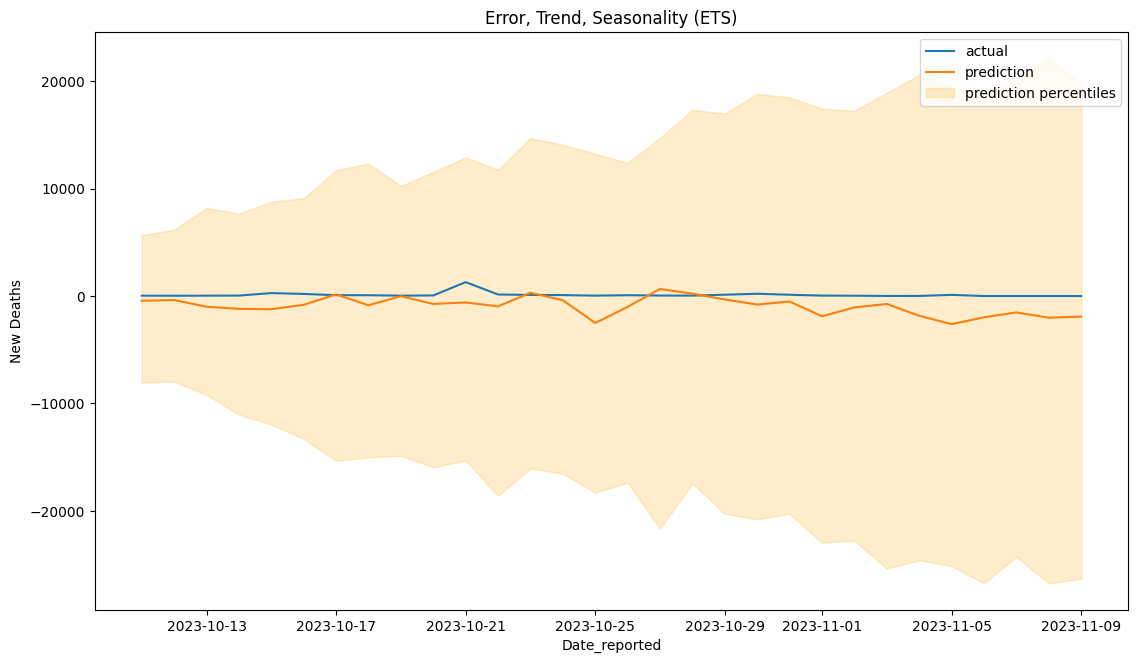

In [20]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Error, Trend, Seasonality (ETS)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [21]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


1327.2550799452833


In [23]:
param_grid = {
    "seasonality": [180, 360],
    'level_sm_input': [0.3, 0.8],
    'seasonality_sm_input': [0.3, 0.5],
    "global_trend_option": ['linear', 'loglinear', 'flat', 'logistic']
}
param_values = list(param_grid.values())

# Compute the cartesian product of the parameter values
all_combinations = list(itertools.product(*param_values))

# If you need the combinations as dictionaries:
combinations_as_dicts = [dict(zip(param_grid.keys(), combination)) for combination in all_combinations]


def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def evaluate_grid(grid, train, date_column, target_column):
    model = DLT(date_col=date_column, 
            response_col=target_column, 
            prediction_percentiles=[5, 95],
            regressor_col=['New_cases'],
            regressor_sign=['='],
            regression_penalty='auto_ridge',
            damped_factor=0.8,
            seed=2, # if you get errors due to less than zero values, try a different seed
            verbose=False,
            **grid)

    bt = BackTester(df=train, 
                    model=model, 
                    forecast_len=90,
                    n_splits=5,
                    window_type='rolling')

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = wmape(predicted_df['actual'], predicted_df['prediction'])
    return grid, score

# Assuming train, date_column, target_column are defined

scores = dict()

# Using ThreadPoolExecutor to parallelize evaluations
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(evaluate_grid, option, train, date_column, target_column): option for option in combinations_as_dicts}
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        scores[json.dumps(option)] = score

# scores now contains the WMAPE scores for each global_trend_option




















chain 1 |██████████| 09:51 Sampling completed
chain 2 |██████████| 09:51 Sampling completed
chain 3 |██████████| 09:51 Sampling completed
chain 4 |██████████| 09:51 Sampling completed
























































chain 1 |██████████| 10:03 Sampling completed
chain 2 |██████████| 10:03 Sampling completed
chain 3 |██████████| 10:03 Sampling completed
chain 4 |██████████| 10:03 Sampling completed
























































chain 1 |██████████| 10:07 Sampling completed
chain 2 |██████████| 10:07 Sampling completed
chain 3 |██████████| 10:07 Sampling completed
chain 4 |██████████| 10:07 Sampling completed
























































chain 1 |██████████| 10:49 Sampling completed
chain 2 |██████████| 10:49 Sampling completed
chain 3 |██████████| 10:49 Sampling completed
chain 4 |██████████| 10:49 Sampling completed










































































chain 1 |██████████| 10:19 Sampling completed
chain 2 |██████████| 10:19 Sampling completed
chain 3 |██████████| 10:19 Sampling completed
chain 4 |██████████| 10:19 Sampling completed
























































chain 1 |██████████| 10:34 Sampling completed
chain 2 |██████████| 10:34 Sampling completed
chain 3 |██████████| 10:34 Sampling completed
chain 4 |██████████| 10:34 Sampling completed
























































chain 1 |██████████| 10:52 Sampling completed
chain 2 |██████████| 10:52 Sampling completed
chain 3 |██████████| 10:52 Sampling completed
chain 4 |██████████| 10:52 Sampling completed
























































chain 1 |██████████| 11:23 Sampling completed
chain 2 |██████████| 11:23 Sampling completed
chain 3 |██████████| 11:23 Sampling completed
chain 4 |██████████| 11:23 Sampling completed










































































chain 1 |██████████| 11:24 Sampling completed
chain 2 |██████████| 11:24 Sampling completed
chain 3 |██████████| 11:24 Sampling completed
chain 4 |██████████| 11:24 Sampling completed

chain 4 |          | 15:08:41 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          | 15:08:41 Iteration: 250 / 250 [100%]  (Sampling)
chain 2 |          | 15:08:41 Iteration: 250 / 250 [100%]  (Sampling)
chain 3 |          | 15:08:41 Iteration: 250 / 250 [100%]  (Sampling)
chain 3 |          | 14:58:10 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          | 14:58:10 Iteration: 250 / 250 [100%]  (Sampling)
chain 3 |          | 14:55:41 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          | 14:55:41 Iteration: 250 / 250 [100%]  (Sampling)
chain 3 |          | 14:55:43 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          | 14:55:43 Iteration: 250 / 250 [100%]  (Sampling)
chain 3 |          | 14:58:48 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          | 14:58:48 Iteration: 250 / 250 [100%]  (Sampling)
chain 3 |          | 14:54:54 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          | 14:54:54 Iteration: 250 / 250 [100%]  (Sampling)
chain 4 |          |










































































chain 1 |██████████| 12:07 Sampling completed                     
chain 2 |██████████| 12:07 Sampling completed                     
chain 3 |██████████| 12:07 Sampling completed
chain 4 |██████████| 12:07 Sampling completed                     

chain 1 |          | 00:00 Status






































chain 1 |██▌       | 00:00 Status



















































































chain 1 |██████████| 12:34 Sampling completed                     
chain 2 |██████████| 12:34 Sampling completed                     
chain 3 |██████████| 12:34 Sampling completed                     
chain 4 |██████████| 12:34 Sampling completed                     






































































































































chain 1 |█████     | 04:44 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |███████▌  | 09:21 Iteration: 100 / 250 [ 40%]  (Warmup)














































chain 1 |██████████| 11:06 Sampling completed                     
chain 2 |██████████| 11:06 Sampling completed                     
chain 3 |██████████| 11:06 Sampling completed                     
chain 4 |██████████| 11:06 Sampling completed                     





































chain 1 |██████████| 10:14 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |          | 10:58 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 11:36 Sampling completed                     
chain 2 |██████████| 11:36 Sampling completed                     
chain 3 |██████████| 11:36 Sampling completed                     
chain 4 |██████████| 11:36 Sampling completed                     

chain 1 |██████████| 11:54 Sampling completed                     
chain 2 |██████████| 11:54 Sampling completed                     
chain 3 |██████████| 11:54 Sampling completed                     
chain 4 |██████████| 11:54 Sampling completed                     

chain 1 |          | 00:00 Status






















chain 1 |██▌       | 00:00 Status












































































































































































































chain 1 |██████████| 13:20 Sampling completed                     
chain 2 |██████████| 13:20 Sampling completed                     
chain 3 |██████████| 13:20 Sampling completed                     
chain 4 |██████████| 13:20 Sampling completed                     

























































chain 1 |█████     | 04:15 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |███████▌  | 09:16 Iteration: 100 / 250 [ 40%]  (Warmup)












































































chain 1 |██████████| 12:09 Sampling completed                     
chain 2 |██████████| 12:09 Sampling completed                     
chain 3 |██████████| 12:09 Sampling completed                     
chain 4 |██████████| 12:09 Sampling completed                     

































chain 1 |██████████| 10:35 Iteration: 200 / 250 [ 80%]  (Warmup)




























































chain 1 |          | 12:03 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 12:31 Sampling completed                     
chain 2 |██████████| 12:31 Sampling completed                     
chain 3 |██████████| 12:31 Sampling completed                     
chain 4 |██████████| 12:31 Sampling completed                     

chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status







































chain 1 |██████████| 12:54 Sampling completed                     
chain 2 |██████████| 12:54 Sampling completed                     
chain 3 |██████████| 12:54 Sampling completed                     
chain 4 |██████████| 12:54 Sampling completed                     


















































































































































































chain 1 |█████     | 04:00 Iteration:   1 / 250 [  0%]  (Warmup)





































































chain 1 |██████████| 13:37 Sampling completed                     
chain 2 |██████████| 13:37 Sampling completed                     
chain 3 |██████████| 13:37 Sampling completed                     
chain 4 |██████████| 13:37 Sampling completed                     









































































































chain 1 |██████████| 09:15 Sampling completed                     
chain 2 |██████████| 09:15 Sampling completed                     
chain 3 |██████████| 09:15 Sampling completed                     
chain 4 |██████████| 09:15 Sampling completed                     



















































chain 1 |███████▌  | 08:00 Iteration: 100 / 250 [ 40%]  (Warmup)




































































































chain 1 |██████████| 08:38 Iteration: 200 / 250 [ 80%]  (Warmup)































































chain 1 |██████████| 08:36 Sampling completed                     
chain 2 |██████████| 08:36 Sampling completed                     
chain 3 |██████████| 08:36 Sampling completed                     
chain 4 |██████████| 08:36 Sampling completed                     


























































































chain 1 |          | 09:03 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 09:18 Sampling completed                     
chain 2 |██████████| 09:18 Sampling completed                     
chain 3 |██████████| 09:18 Sampling completed                     
chain 4 |██████████| 09:18 Sampling completed                     

chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status























































chain 1 |█████     | 03:46 Iteration:   1 / 250 [  0%]  (Warmup)





































































































































chain 1 |██████████| 10:13 Sampling completed                     
chain 2 |██████████| 10:13 Sampling completed                     
chain 3 |██████████| 10:13 Sampling completed                     
chain 4 |██████████| 10:13 Sampling completed                     





















































































































































chain 1 |██████████| 10:18 Sampling completed                     
chain 2 |██████████| 10:18 Sampling completed                     
chain 3 |██████████| 10:18 Sampling completed                     
chain 4 |██████████| 10:18 Sampling completed                     






























































































chain 1 |██████████| 08:44 Iteration: 200 / 250 [ 80%]  (Warmup)




























































chain 1 |██████████| 09:41 Sampling completed                     
chain 2 |██████████| 09:41 Sampling completed                     
chain 3 |██████████| 09:41 Sampling completed                     
chain 4 |██████████| 09:41 Sampling completed                     

























































































chain 1 |          | 09:27 Iteration: 226 / 250 [ 90%]  (Sampling)









































chain 1 |██████████| 10:00 Sampling completed                     
chain 2 |██████████| 10:00 Sampling completed                     
chain 3 |██████████| 10:00 Sampling completed                     
chain 4 |██████████| 10:00 Sampling completed                     

chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status
























































































chain 1 |█████     | 04:25 Iteration:   1 / 250 [  0%]  (Warmup)























































































chain 1 |██████████| 11:12 Sampling completed                     
chain 2 |██████████| 11:12 Sampling completed                     
chain 3 |██████████| 11:12 Sampling completed                     
chain 4 |██████████| 11:12 Sampling completed                     





































































































































































chain 1 |███████▌  | 08:55 Iteration: 100 / 250 [ 40%]  (Warmup)


































































chain 1 |██████████| 11:33 Sampling completed                     
chain 2 |██████████| 11:33 Sampling completed                     
chain 3 |██████████| 11:33 Sampling completed                     
chain 4 |██████████| 11:33 Sampling completed                     











































chain 1 |██████████| 09:54 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |██████████| 10:53 Sampling completed                     
chain 2 |██████████| 10:53 Sampling completed                     
chain 3 |██████████| 10:53 Sampling completed                     
chain 4 |██████████| 10:53 Sampling completed                     






































































































chain 1 |          | 11:07 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 11:26 Sampling completed                     
chain 2 |██████████| 11:26 Sampling completed                     
chain 3 |██████████| 11:26 Sampling completed                     
chain 4 |██████████| 11:26 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status













































































































chain 1 |█████     | 04:30 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































































































chain 1 |██████████| 12:47 Sampling completed                     
chain 2 |██████████| 12:47 Sampling completed                     
chain 3 |██████████| 12:47 Sampling completed                     
chain 4 |██████████| 12:47 Sampling completed                     




























































































chain 1 |███████▌  | 09:04 Iteration: 100 / 250 [ 40%]  (Warmup)





















































chain 1 |██████████| 11:33 Sampling completed                     
chain 2 |██████████| 11:33 Sampling completed                     
chain 3 |██████████| 11:33 Sampling completed                     
chain 4 |██████████| 11:33 Sampling completed                     

































chain 1 |██████████| 09:57 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |██████████| 11:15 Sampling completed                     
chain 2 |██████████| 11:15 Sampling completed                     
chain 3 |██████████| 11:15 Sampling completed                     
chain 4 |██████████| 11:15 Sampling completed                     




































































































chain 1 |          | 10:51 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 11:14 Sampling completed                     
chain 2 |██████████| 11:14 Sampling completed                     
chain 3 |██████████| 11:14 Sampling completed                     
chain 4 |██████████| 11:14 Sampling completed                     

chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status

















































































































chain 1 |█████     | 04:50 Iteration:   1 / 250 [  0%]  (Warmup)
































































































































































































































chain 1 |███████▌  | 10:07 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |██████████| 13:18 Sampling completed                     
chain 2 |██████████| 13:18 Sampling completed                     
chain 3 |██████████| 13:18 Sampling completed                     
chain 4 |██████████| 13:18 Sampling completed                     


























































































chain 1 |██████████| 12:06 Sampling completed                     
chain 2 |██████████| 12:06 Sampling completed                     
chain 3 |██████████| 12:06 Sampling completed                     
chain 4 |██████████| 12:06 Sampling completed                     

























































































chain 1 |██████████| 12:31 Sampling completed                     
chain 2 |██████████| 12:31 Sampling completed                     
chain 3 |██████████| 12:31 Sampling completed                     
chain 4 |██████████| 12:31 Sampling completed                     


chain 1 |██████████| 11:07 Iteration: 200 / 250 [ 80%]  (Warmup)


















































chain 1 |          | 12:29 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 12:51 Sampling completed                     
chain 2 |██████████| 12:51 Sampling completed                     
chain 3 |██████████| 12:51 Sampling completed                     
chain 4 |██████████| 12:51 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status





















































































































chain 1 |█████     | 04:09 Iteration:   1 / 250 [  0%]  (Warmup)























































































































































































chain 1 |███████▌  | 08:42 Iteration: 100 / 250 [ 40%]  (Warmup)



































































chain 1 |██████████| 09:49 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 11:54 Sampling completed                     
chain 2 |██████████| 11:54 Sampling completed                     
chain 3 |██████████| 11:54 Sampling completed                     
chain 4 |██████████| 11:54 Sampling completed                     





































































































chain 1 |██████████| 11:53 Sampling completed                     
chain 2 |██████████| 11:53 Sampling completed                     
chain 3 |██████████| 11:53 Sampling completed                     
chain 4 |██████████| 11:53 Sampling completed                     



































chain 1 |██████████| 12:49 Sampling completed                     
chain 2 |██████████| 12:49 Sampling completed                     
chain 3 |██████████| 12:49 Sampling completed                     
chain 4 |██████████| 12:49 Sampling completed                     
































































chain 1 |          | 10:53 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 11:06 Sampling completed                     
chain 2 |██████████| 11:06 Sampling completed                     
chain 3 |██████████| 11:06 Sampling completed                     
chain 4 |██████████| 11:06 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status




















































































































chain 1 |█████     | 04:08 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |███████▌  | 08:25 Iteration: 100 / 250 [ 40%]  (Warmup)














































































































chain 1 |██████████| 09:34 Iteration: 200 / 250 [ 80%]  (Warmup)








































































































chain 1 |██████████| 11:58 Sampling completed                     
chain 2 |██████████| 11:58 Sampling completed                     
chain 3 |██████████| 11:58 Sampling completed                     
chain 4 |██████████| 11:58 Sampling completed                     




































































































chain 1 |██████████| 11:59 Sampling completed                     
chain 2 |██████████| 11:59 Sampling completed                     
chain 3 |██████████| 11:59 Sampling completed                     
chain 4 |██████████| 11:59 Sampling completed                     
















































chain 1 |██████████| 11:32 Sampling completed                     
chain 2 |██████████| 11:32 Sampling completed                     
chain 3 |██████████| 11:32 Sampling completed                     
chain 4 |██████████| 11:32 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status

































chain 1 |██████████| 12:54 Sampling completed                     
chain 2 |██████████| 12:54 Sampling completed                     
chain 3 |██████████| 12:54 Sampling completed                     
chain 4 |██████████| 12:54 Sampling completed                     






































































































































chain 1 |█████     | 03:54 Iteration:   1 / 250 [  0%]  (Warmup)





































































































chain 1 |███████▌  | 08:31 Iteration: 100 / 250 [ 40%]  (Warmup)





































































chain 1 |██████████| 09:40 Iteration: 200 / 250 [ 80%]  (Warmup)




































































































chain 1 |          | 10:55 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 10:59 Sampling completed                     
chain 2 |██████████| 10:59 Sampling completed                     
chain 3 |██████████| 10:59 Sampling completed                     
chain 4 |██████████| 10:59 Sampling completed                     

chain 1 |          | 00:00 Status



























chain 1 |██▌       | 00:00 Status


















chain 1 |██████████| 11:47 Sampling completed                     
chain 2 |██████████| 11:47 Sampling completed                     
chain 3 |██████████| 11:47 Sampling completed                     
chain 4 |██████████| 11:47 Sampling completed                     




























































































chain 1 |██████████| 11:46 Sampling completed                     
chain 2 |██████████| 11:46 Sampling completed                     
chain 3 |██████████| 11:46 Sampling completed                     
chain 4 |██████████| 11:47 Sampling completed                     














































































chain 1 |██████████| 12:56 Sampling completed                     
chain 2 |██████████| 12:56 Sampling completed                     
chain 3 |██████████| 12:56 Sampling completed                     
chain 4 |██████████| 12:56 Sampling completed                     




















































































chain 1 |█████     | 03:38 Iteration:   1 / 250 [  0%]  (Warmup)

























































































chain 1 |███████▌  | 08:18 Iteration: 100 / 250 [ 40%]  (Warmup)

































































chain 1 |██████████| 09:28 Iteration: 200 / 250 [ 80%]  (Warmup)















































































chain 1 |          | 10:50 Iteration: 226 / 250 [ 90%]  (Sampling)
















































chain 1 |██████████| 11:21 Sampling completed                     
chain 2 |██████████| 11:21 Sampling completed                     
chain 3 |██████████| 11:21 Sampling completed                     
chain 4 |██████████| 11:21 Sampling completed                     

chain 1 |          | 00:00 Status























chain 1 |██▌       | 00:00 Status






















chain 1 |██████████| 11:34 Sampling completed                     
chain 2 |██████████| 11:34 Sampling completed                     
chain 3 |██████████| 11:34 Sampling completed                     
chain 4 |██████████| 11:34 Sampling completed                     
















































































































chain 1 |██████████| 11:59 Sampling completed                     
chain 2 |██████████| 11:59 Sampling completed                     
chain 3 |██████████| 11:59 Sampling completed                     
chain 4 |██████████| 11:59 Sampling completed                     



























































































chain 1 |█████     | 03:53 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |██████████| 13:04 Sampling completed                     
chain 2 |██████████| 13:04 Sampling completed                     
chain 3 |██████████| 13:04 Sampling completed                     
chain 4 |██████████| 13:04 Sampling completed                     






































































































































chain 1 |███████▌  | 08:32 Iteration: 100 / 250 [ 40%]  (Warmup)





























































































chain 1 |██████████| 09:47 Iteration: 200 / 250 [ 80%]  (Warmup)




















































































chain 1 |          | 11:11 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 11:34 Sampling completed                     
chain 2 |██████████| 11:34 Sampling completed                     
chain 3 |██████████| 11:34 Sampling completed                     
chain 4 |██████████| 11:34 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status

































































chain 1 |██████████| 11:50 Sampling completed                     
chain 2 |██████████| 11:50 Sampling completed                     
chain 3 |██████████| 11:50 Sampling completed                     
chain 4 |██████████| 11:50 Sampling completed                     




































































































chain 1 |██████████| 11:55 Sampling completed                     
chain 2 |██████████| 11:55 Sampling completed                     
chain 3 |██████████| 11:55 Sampling completed                     
chain 4 |██████████| 11:55 Sampling completed                     


















































































































chain 1 |█████     | 04:19 Iteration:   1 / 250 [  0%]  (Warmup)















































































chain 1 |██████████| 13:08 Sampling completed                     
chain 2 |██████████| 13:08 Sampling completed                     
chain 3 |██████████| 13:08 Sampling completed                     
chain 4 |██████████| 13:08 Sampling completed                     




























































































chain 1 |███████▌  | 09:03 Iteration: 100 / 250 [ 40%]  (Warmup)































































































chain 1 |██████████| 10:17 Iteration: 200 / 250 [ 80%]  (Warmup)




























































































chain 1 |          | 11:31 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 11:34 Sampling completed                     
chain 2 |██████████| 11:34 Sampling completed                     
chain 3 |██████████| 11:33 Sampling completed                     
chain 4 |██████████| 11:33 Sampling completed                     










chain 1 |          | 00:00 Status

































chain 1 |██▌       | 00:00 Status














chain 1 |██████████| 11:22 Sampling completed                     
chain 2 |██████████| 11:22 Sampling completed                     
chain 3 |██████████| 11:22 Sampling completed                     
chain 4 |██████████| 11:22 Sampling completed                     




























































































chain 1 |██████████| 10:57 Sampling completed                     
chain 2 |██████████| 10:57 Sampling completed                     
chain 3 |██████████| 10:57 Sampling completed                     
chain 4 |██████████| 10:57 Sampling completed                     














































































chain 1 |█████     | 04:26 Iteration:   1 / 250 [  0%]  (Warmup)



















































































































chain 1 |██████████| 12:58 Sampling completed                     
chain 2 |██████████| 12:58 Sampling completed                     
chain 3 |██████████| 12:58 Sampling completed                     
chain 4 |██████████| 12:58 Sampling completed                     








































































chain 1 |███████▌  | 09:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















































































chain 1 |██████████| 10:12 Iteration: 200 / 250 [ 80%]  (Warmup)























































































chain 1 |          | 11:33 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 11:36 Sampling completed                     
chain 2 |██████████| 11:36 Sampling completed                     
chain 3 |██████████| 11:36 Sampling completed                     
chain 4 |██████████| 11:36 Sampling completed                     












chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status













chain 1 |██████████| 11:10 Sampling completed                     
chain 2 |██████████| 11:10 Sampling completed                     
chain 3 |██████████| 11:10 Sampling completed                     
chain 4 |██████████| 11:10 Sampling completed                     















































































chain 1 |██████████| 11:56 Sampling completed                     
chain 2 |██████████| 11:56 Sampling completed                     
chain 3 |██████████| 11:56 Sampling completed                     
chain 4 |██████████| 11:56 Sampling completed                     





























































































































chain 1 |█████     | 04:29 Iteration:   1 / 250 [  0%]  (Warmup)




























































































































chain 1 |██████████| 12:37 Sampling completed                     
chain 2 |██████████| 12:37 Sampling completed                     
chain 3 |██████████| 12:37 Sampling completed                     
chain 4 |██████████| 12:37 Sampling completed                     


























































































chain 1 |███████▌  | 09:06 Iteration: 100 / 250 [ 40%]  (Warmup)












































































chain 1 |██████████| 10:29 Iteration: 200 / 250 [ 80%]  (Warmup)

































































chain 1 |██████████| 11:16 Sampling completed                     
chain 2 |██████████| 11:16 Sampling completed                     
chain 3 |██████████| 11:16 Sampling completed                     
chain 4 |██████████| 11:16 Sampling completed                     












































chain 1 |██████████| 11:52 Sampling completed                     
chain 2 |██████████| 11:52 Sampling completed                     
chain 3 |██████████| 11:52 Sampling completed                     
chain 4 |██████████| 11:52 Sampling completed                     

chain 1 |          | 00:00 Status






















chain 1 |██▌       | 00:00 Status






















































chain 1 |██████████| 11:57 Sampling completed                     
chain 2 |██████████| 11:57 Sampling completed                     
chain 3 |██████████| 11:57 Sampling completed                     
chain 4 |██████████| 11:57 Sampling completed                     






















































































































































chain 1 |█████     | 04:28 Iteration:   1 / 250 [  0%]  (Warmup)













































































































































chain 1 |███████▌  | 09:05 Iteration: 100 / 250 [ 40%]  (Warmup)


































chain 1 |██████████| 13:01 Sampling completed                     
chain 2 |██████████| 13:01 Sampling completed                     
chain 3 |██████████| 13:01 Sampling completed                     
chain 4 |██████████| 13:01 Sampling completed                     






























































































chain 1 |██████████| 10:13 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |██████████| 10:54 Sampling completed                     
chain 2 |██████████| 10:54 Sampling completed                     
chain 3 |██████████| 10:54 Sampling completed                     
chain 4 |██████████| 10:54 Sampling completed                     









































































chain 1 |          | 11:34 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 11:47 Sampling completed                     
chain 2 |██████████| 11:47 Sampling completed                     
chain 3 |██████████| 11:47 Sampling completed                     
chain 4 |██████████| 11:47 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status




























































chain 1 |██████████| 11:59 Sampling completed                     
chain 2 |██████████| 11:59 Sampling completed                     
chain 3 |██████████| 11:59 Sampling completed                     
chain 4 |██████████| 11:59 Sampling completed                     











































































































































chain 1 |█████     | 03:57 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |███████▌  | 08:42 Iteration: 100 / 250 [ 40%]  (Warmup)




























































chain 1 |██████████| 11:08 Sampling completed                     
chain 2 |██████████| 11:08 Sampling completed                     
chain 3 |██████████| 11:08 Sampling completed                     
chain 4 |██████████| 11:08 Sampling completed                     

































chain 1 |██████████| 10:00 Iteration: 200 / 250 [ 80%]  (Warmup)
























































chain 1 |██████████| 12:50 Sampling completed                     
chain 2 |██████████| 12:50 Sampling completed                     
chain 3 |██████████| 12:50 Sampling completed                     
chain 4 |██████████| 12:50 Sampling completed                     

























































































chain 1 |          | 11:23 Iteration: 226 / 250 [ 90%]  (Sampling)






















































chain 1 |██████████| 12:04 Sampling completed                     
chain 2 |██████████| 12:04 Sampling completed                     
chain 3 |██████████| 12:04 Sampling completed                     
chain 4 |██████████| 12:04 Sampling completed                     

chain 1 |          | 00:00 Status
















chain 1 |██▌       | 00:00 Status




























































chain 1 |██████████| 12:03 Sampling completed                     
chain 2 |██████████| 12:03 Sampling completed                     
chain 3 |██████████| 12:03 Sampling completed                     
chain 4 |██████████| 12:03 Sampling completed                     















































































































































chain 1 |█████     | 04:35 Iteration:   1 / 250 [  0%]  (Warmup)






























































































































chain 1 |██████████| 10:53 Sampling completed                     
chain 2 |██████████| 10:52 Sampling completed                     
chain 3 |██████████| 10:52 Sampling completed                     
chain 4 |██████████| 10:52 Sampling completed                     




































































chain 1 |███████▌  | 09:09 Iteration: 100 / 250 [ 40%]  (Warmup)


















































































chain 1 |██████████| 10:15 Iteration: 200 / 250 [ 80%]  (Warmup)























































































chain 1 |██████████| 11:01 Sampling completed                     
chain 2 |██████████| 11:01 Sampling completed                     
chain 3 |██████████| 11:01 Sampling completed                     
chain 4 |██████████| 11:01 Sampling completed                     

chain 1 |          | 00:00 Status


























chain 1 |██▌       | 00:00 Status




















chain 1 |██████████| 12:49 Sampling completed                     
chain 2 |██████████| 12:49 Sampling completed                     
chain 3 |██████████| 12:49 Sampling completed                     
chain 4 |██████████| 12:49 Sampling completed                     












































































chain 1 |██████████| 10:20 Sampling completed                     
chain 2 |██████████| 10:20 Sampling completed                     
chain 3 |██████████| 10:20 Sampling completed                     
chain 4 |██████████| 10:20 Sampling completed                     



















































































































chain 1 |█████     | 04:28 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































chain 1 |██████████| 11:13 Sampling completed                     
chain 2 |██████████| 11:13 Sampling completed                     
chain 3 |██████████| 11:13 Sampling completed                     
chain 4 |██████████| 11:13 Sampling completed                     





















































































chain 1 |██████████| 09:41 Iteration: 200 / 250 [ 80%]  (Warmup)










































































chain 1 |          | 10:28 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 10:58 Sampling completed                     
chain 2 |██████████| 10:58 Sampling completed                     
chain 3 |██████████| 10:58 Sampling completed                     
chain 4 |██████████| 10:58 Sampling completed                     

chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status


























































chain 1 |██████████| 11:06 Sampling completed                     
chain 2 |██████████| 11:06 Sampling completed                     
chain 3 |██████████| 11:06 Sampling completed                     
chain 4 |██████████| 11:06 Sampling completed                     



















































































































































chain 1 |██████████| 13:27 Sampling completed                     
chain 2 |██████████| 13:27 Sampling completed                     
chain 3 |██████████| 13:27 Sampling completed                     
chain 4 |██████████| 13:27 Sampling completed                     



































































chain 1 |█████     | 04:37 Iteration:   1 / 250 [  0%]  (Warmup)




















































In [ ]:
best_params = json.loads(min(scores, key=scores.get))
scores

{'flat': 0.10583229908867284,
 'loglinear': 0.10555178892110227,
 'linear': 0.10555006364810433,
 'logistic': 0.10908173968786739}

In [ ]:
dlt = DLT(date_col=date_column, 
        response_col=target_column, 
        seasonality=7,
        prediction_percentiles=[5, 95],
        regressor_col=['New_cases'],
        regressor_sign=['='],
        regression_penalty='auto_ridge',
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **best_params)
p = dlt.predict(df=valid[[date_column, 'New_cases']])
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)


In [ ]:
ktr = KTR(date_col=date_column, 
        response_col=target_column, 
        seasonality=[7, 28],
        prediction_percentiles=[5, 95],
        regressor_col=['New_cases'],
        seed=2,
        verbose=False)

ktr.fit(df=train)

p = ktr.predict(df=valid[[date_column, 'New_cases']])
p = p.merge(valid, on=date_column, how='left')

print(wmape(p[target_column], p['prediction']))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1280/96, 720/96))
ax.plot(p[date_column], p[target_column], label='actual')
ax.plot(p[date_column], p['prediction'], label='prediction')
ax.fill_between(p[date_column], p['prediction_5'], p['prediction_95'], alpha=0.2, color='orange', label='prediction percentiles')
ax.set_title('Damped Local Trend (DLT)')
ax.set_ylabel('New Deaths')
ax.set_xlabel(date_column)
ax.legend()
plt.show()

In [ ]:
p[target_column].mean()
rmse=sqrt(mean_squared_error(p['prediction'],p[target_column]))
print(rmse)
